# Read in the datasets

In [174]:
# ! pip install torchsummary
# ! pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cpu

In [175]:
import os
import time
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchsampler import ImbalancedDatasetSampler
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, \
precision_recall_fscore_support

In [176]:
import warnings

In [177]:
btc = pd.read_feather('./datasets/BTC_USDT-1h-test.feather')
eth = pd.read_feather('./datasets/ETH_USDT-1h-test.feather')
bnb = pd.read_feather('./datasets/BNB_USDT-1h-test.feather')

In [178]:
btc.head()

,date,open,high,low,close,volume,ema_20,ema_50,ema_200,rsi,macd,macdsignal,macdhist,adosc,obv,mfi,adx,plus_di,minus_di,label
0,2017-11-14 10:00:00+00:00,6529.73,6560.00,6460.00,6531.95,63.119944,6474.585458,6385.769319,6607.539374,55.084082,68.335561,81.749810,-13.414249,12.403486,3048.617792,74.492978,18.409559,19.559038,15.748152,0
1,2017-11-14 11:00:00+00:00,6497.26,6530.22,6400.00,6410.00,71.702833,6468.434462,6386.719542,6605.573808,48.553563,55.081344,76.416117,-21.334773,-2.922274,2976.914959,66.047241,17.209545,18.276365,17.697414,0
2,2017-11-14 12:00:00+00:00,6410.03,6437.00,6311.07,6428.46,105.599136,6464.627370,6388.356423,6603.811482,49.528998,45.541871,70.241268,-24.699397,20.116322,3082.514095,57.439950,16.713432,17.122288,21.039168,0
3,2017-11-14 13:00:00+00:00,6411.00,6429.19,6343.21,6379.00,49.713800,6456.472383,6387.989504,6601.574552,46.959920,33.603402,62.913695,-29.310293,25.063229,3032.800295,52.751740,16.252756,16.362575,20.105664,1
4,2017-11-14 14:00:00+00:00,6379.00,6498.00,6355.25,6462.92,52.002929,6457.086441,6390.927955,6600.194904,51.551808,30.561429,56.443242,-25.881813,33.222515,3084.803224,50.151450,15.106202,18.702903,18.627869,0


# Global Presets

In [179]:
RANDOM_SEED = 11919925
BATCH_SIZE = 256
LR = 1e-3
TIMEPERIOD = 33
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(device)

## Check datasets' length

In [181]:
datasets_list = [btc, eth, bnb]

In [182]:
for data in datasets_list:
    print(data['label'].value_counts())
    print()

label
0    54553
1     1100
2     1100
Name: count, dtype: int64

label
0    54627
1     1063
2     1063
Name: count, dtype: int64

label
0    54589
1     1082
2     1082
Name: count, dtype: int64



In [183]:
btc.shape

(56753, 20)

In [184]:
eth.shape

(56753, 20)

In [185]:
bnb.shape

(56753, 20)

# Final Dataset Creation

## Custom Transform: To Tensor

In [186]:
def to_tensor(arr, dtype=torch.float32):
    """
    Convert a Numpy array into a tensor of dtype torch.float32, for 
    compatibility with the MPS device on an ARM64 Macbook.
    """
    tsr = torch.tensor(arr, dtype=dtype)
    return tsr

## Custom Transform: Per-Image Normalisation

In [187]:
def normalise(tsr):
    """
    Normalise the tensor according to zero mean and unit standard deviation.
    """
    tsr_mean = torch.mean(tsr, dim=0)
    tsr_stdev = torch.std(tsr, dim=0)
    
    return (tsr - tsr_mean) / tsr_stdev

## Custom Transform: Reshape Tensor to have channel dimension first

In [188]:
def reshape_tsr(tsr):
    """
    Reshape a tensor to have the channel dimension first, which is only 1
    because the images do not have colour channels.
    """
    return tsr.reshape(1, tsr.shape[0], tsr.shape[1])

## Custom Dataset class

In [189]:
class CryptoImageDataset(Dataset):
    """
    Creates a cryptocurrency image dataset.
    
    The object takes in a labelled dataframe, a preset vertical dimension, an
    """
    def __init__(self, dataframe: pd.DataFrame, img_vertical_dim: int, **transforms):
        """
        
        """
        self.dataframe = dataframe
        self.vertical_dim = img_vertical_dim
        self.transforms = transforms
        
        # Callable Attributes
        self.img_dates = dataframe["date"].iloc[self.vertical_dim-1:].reset_index(drop=True)
        self.img_labels = dataframe["label"].iloc[self.vertical_dim-1:].reset_index(drop=True)
    
    def __len__(self):
        """
        The length of the image dataset is the length of the labelled dataframe 
        minus the vertical dimension of the image, plus 1 (because an image is 
        valid when there is enough data in the rolling window, so the number of
        images is inclusive of the first valid image.)
        
        For example: if the dataframe has length 10, and the image has a vertical
        length of 4, then the number of images is 10 - 4 + 1 = 7.
        """
        return len(self.dataframe) - self.vertical_dim + 1
    
    def __getitem__(self, idx):
        """
        idx: The zero-based index of the image dataset, not the dataframe.
        """        
        # Get the raw array of the image
        img_array = self.dataframe.iloc[idx:(idx+self.vertical_dim), 1:-1].values
        
        # Get the index value at the label of interest, which is the last row of
        # each image
        idx_at_label = idx + self.vertical_dim - 1
        
        # Get the label of the image
        label = int(self.dataframe["label"].iloc[idx_at_label])  # dtype: int
        
        for transform in self.transforms.values():
            img_array = transform(img_array)
        
        return img_array, label
    
    def get_labels(self):
        return self.img_labels


## FOR HYPERPARAMETER CHOOSING: DatasetGenerator class

In [190]:
class DatasetGenerator(object):
    def __init__(self, dataframe: pd.DataFrame, batch_size: int, 
                 timeperiod: int,
                 train_start_idx: int,
                 test_end_idx: int,
                 train_cutoff: str="2021-07-01 00:00:00+00:00", 
                 val_cutoff: str="2023-01-01 00:00:00+00:00",
                 **transforms):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.timeperiod = timeperiod
        self.train_start_idx = train_start_idx
        self.test_end_idx = test_end_idx
        self.train_cutoff = train_cutoff
        self.val_cutoff = val_cutoff
        self.transforms = transforms
        
        self.train_df, self.val_df, self.test_df = self._split()
        self.train_imgs, self.val_imgs, self.test_imgs = self._generate_image_datasets(
            self.train_df, self.val_df, self.test_df
        )
        self.train_loader, self.val_loader, self.test_loader = self._generate_image_dataloaders(
            self.train_imgs, self.val_imgs, self.test_imgs, batch_size=self.batch_size
        )
        
        self.img_shape = [self.train_imgs.__getitem__(i)[0].shape for i in range(1)][0]
    
    def create_data(self):
        """
        Wrapper method to create ready-to-train dataloaders for a given dataset,
        as well as other attributes like image shape for the model.
        """
        return self.train_loader, self.val_loader, self.test_loader
    
    def get_img_shape(self):
        """
        Retrieves the image shape for computation of dimension within a CNN.
        """
        return self.img_shape
    
    def _split(self):
        """
        Split the dataframe into training, validation and testing subsets.
        
        The splitting will be performed according to the preset cutoff dates, 
        unless stated otherwise:
        - Training set: start_date → 2021-06-30 23:00:00+00:00 inclusive
        - Validation set: 2021-07-01 00:00:00+00:00 → 2022-12-31 23:00:00+00:00 inclusive
        - Testing set: 2023-01-01 00:00:00+00:00 → end_date inclusive
        """
        dataframe_train_cutoff_idx = self.dataframe[self.dataframe["date"]==self.train_cutoff].index.item()
        dataframe_val_cutoff_idx = self.dataframe[self.dataframe["date"]==self.val_cutoff].index.item()

        train_df = self.dataframe.iloc[ self.train_start_idx : dataframe_train_cutoff_idx ]
        val_df = self.dataframe.iloc[ dataframe_train_cutoff_idx-self.timeperiod+1 : dataframe_val_cutoff_idx ]
        test_df = self.dataframe.iloc[ dataframe_val_cutoff_idx-self.timeperiod+1 : self.test_end_idx ]
        
        return train_df, val_df, test_df
    
    def _generate_image_datasets(self, train_df, val_df, test_df):
        """
        Generates the image datasets according to the splits.
        """
        train_imgs = CryptoImageDataset(train_df, self.timeperiod, **self.transforms)
        val_imgs = CryptoImageDataset(val_df, self.timeperiod, **self.transforms)
        test_imgs = CryptoImageDataset(test_df, self.timeperiod, **self.transforms)

        return train_imgs, val_imgs, test_imgs
    
    def _generate_image_dataloaders(self, train_imgs, val_imgs, test_imgs, batch_size, shuffle=False):
        """
        Generate image dataloaders according to the given image datasets.
        """
        train_loader = DataLoader(train_imgs, batch_size=batch_size, 
                                  sampler=ImbalancedDatasetSampler(train_imgs),
                                  shuffle=shuffle)
        val_loader = DataLoader(val_imgs, batch_size=batch_size, shuffle=shuffle)
        test_loader = DataLoader(test_imgs, batch_size=batch_size, shuffle=shuffle)

        return train_loader, val_loader, test_loader


# Training Functions

Specifics of training:

- The loss will be the Categorical Cross Entropy Loss, weighted inversely proportional to the number of training examples for each class in order to battle class imbalance.
- Filter size for convolutional layers: fixed at $3\times3$.
- The hyperparameters that will be tuned using a small sample of the dataset using a search:
    - Number of time periods $L$ for image creation, which will determine the vertical dimension of the image in the final dataset
    - The initial learning rate `lr`

## Model Saver class

In [191]:
class ModelSaver(object):
    """
    Saves model weights every epoch as long as the validation loss decreases.
    
    As a new version is saved, all old versions are deleted, thus saves storage.
    
    """
    def __init__(self, model, checkpoints_path):
        self.model = model
        self.model_id = self.model.model_id
        self.model_name_with_id = f'{self.model.__class__.__name__}-{self.model_id}'
        self.checkpoints_path = checkpoints_path
        self.partial_model_path = f'{self.checkpoints_path}/{self.model_name_with_id}'
        self.min_val_loss = np.inf
        self.epochs = []
        
        if not os.path.exists(self.checkpoints_path):
            os.makedirs(self.checkpoints_path)

    def save(self, epoch_num, val_loss):
        # Save model weights if validation loss decreases
        if val_loss < self.min_val_loss:
            self.min_val_loss = val_loss
            self.epochs.append(epoch_num)
            torch.save(self.model.state_dict(), f"{self.partial_model_path}_EP{epoch_num}.pt")
            if len(self.epochs) >= 2:
                os.remove(f'{self.partial_model_path}_EP{self.epochs[-2]}.pt')
    
    def get_best_model_name(self):
        """
        Retrieves the name of the best model when training finishes.
        """
        return f'{self.model_name_with_id}_EP{self.epochs[-1]}.pt'


## Early Stopping Validator

In [192]:
class EarlyStoppingValidator(object):
    """
    A custom validator class for early stopping conditions. It sets the threshold for
    early stopping of network training based on the divergence between training loss 
    and validation loss.
    
    If validation loss is greater than the current minimum validation loss plus some
    threshold for a period of time exceeding the "patience" level, the training loop
    should break.
    """
    def __init__(self, patience, delta):
        self.patience = patience
        self.delta = delta
        self.min_val_loss = np.inf
        self.counter = 0
        
    def early_stop(self, val_loss):
        """
        Validate the early stopping conditions based on the observed validation loss.
        """
        if val_loss < self.min_val_loss:  # Keeps track of the minimum validation loss
            self.min_val_loss = val_loss
            self.counter = 0  # reset the counter
        elif val_loss >= self.min_val_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

## Model Trainer

In [193]:
class ModelTrainerTester(object):
    """
    A wrapper model trainer class that will create datasets, dataloaders
    and train them on the specified settings.
    
    Also test the best model and store all relevant statistics.
    """
    def __init__(self, model, device, lr, batch_size, train_imgs, loader_train, loader_val, 
                 loader_test, checkpoints_path, n_epochs=500, random=False, random_state=None):
        # Training parameters
        self.model = model
        self.device = device
        self.lr = lr
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.loader_train = loader_train
        self.loader_val = loader_val
        self.loader_test = loader_test
        
        self.random = random
        self.random_state = random_state
        self.trained = False
        
        # Loss function, optimizer, learning rate scheduler, early stopper
        self.train_labels = train_imgs.img_labels
#         self.class_weights = self.get_inverse_prop_weights(self.train_labels, self.device)
        self.class_weights = None
        self.loss_fn = self._get_loss_fn(weight=self.class_weights)
        self.optimizer = self._get_optimizer()
        self.lr_scheduler = self._get_lr_scheduler(self.optimizer)
        self.early_stopper = self._get_early_stopper()
        
        # Model saver for weight saving
        self.model_name = f"{self.model.__class__.__name__}"
        self.path = checkpoints_path
        self.model_saver = self._get_model_saver(self.model, self.path)
        
        # ======================================================
        # STORE: Train-validation losses and f1-scores
        self.train_loss_list = []
        self.val_loss_list = []
        self.train_f1_list = []
        self.val_f1_list = []
        
        # ======================================================
        # STORING STATISTICS OF BEST MODEL ON THE TRAINING SET (UPDATES BY CALLING train_eval())
        # Per-class validation statistics
        self.train_precision_per_class = None
        self.train_recall_per_class = None
        self.train_f1_score_per_class = None
        self.train_support_per_class = None
        
        # Macro average of validation statistics
        self.train_precision = None
        self.train_recall = None
        self.train_f1_score = None
        
        # ======================================================
        # STORING STATISTICS OF BEST MODEL ON THE VALIDATION SET (UPDATES BY CALLING train_eval())
        # Per-class validation statistics
        self.val_precision_per_class = None
        self.val_recall_per_class = None
        self.val_f1_score_per_class = None
        self.val_support_per_class = None
        
        # Macro average of validation statistics
        self.val_precision = None
        self.val_recall = None
        self.val_f1_score = None
        
        # ======================================================
        # STORING STATISTICS OF BEST MODEL ON THE TESTING SET (UPDATES BY CALLING test())
        # Per-class test statistics
        self.test_precision_per_class = None
        self.test_recall_per_class = None
        self.test_f1_score_per_class = None
        self.test_support_per_class = None
        
        # Macro average of validation statistics
        self.test_precision = None
        self.test_recall = None
        self.test_f1_score = None
        
        # Test predictions and confusion matrix
        self.test_pred_y = None
        self.test_true_y = None
        self.test_confusion_matrix = None
    
    def train_eval(self):
        """
        Trains and evaluates the model.
        """
        # ===============================================================================
        # TRAINING INITIALISATION
        # Send the model to the specified device
        self.model.to(self.device)
        # Track the min validation loss
        min_val_loss = np.inf
        # Start the timer
        training_start_time = time.time()
        
        # Loop through the epochs
        for epoch in range(self.n_epochs):
            # ===============================================================================
            # EPOCH INITIALISATION
            epoch_train_loss, epoch_val_loss = 0.0, 0.0
            train_true_y_concat, train_pred_y_concat = torch.LongTensor(), torch.LongTensor()
            val_true_y_concat, val_pred_y_concat = torch.LongTensor(), torch.LongTensor()
            
            # ===============================================================================
            # EPOCH TRAINING LOOP
            self.model.train()
            for train_x, train_y in self.loader_train:
                # Move data and target to the same device as the model
                train_x_device = train_x.to(self.device)
                train_y_device = train_y.to(self.device)
                # Set zero gradients
                self.optimizer.zero_grad()
                # Forward Propagation to get predicted outcome, and argmax to cpu
                train_pred_y_device = self.model(train_x_device)
                train_pred_y_cpu = torch.argmax(train_pred_y_device, dim=1).cpu()
                # Concat the true value and the prediction to the cpu tensors
                train_true_y_concat = torch.cat((train_true_y_concat, train_y))
                train_pred_y_concat = torch.cat((train_pred_y_concat, train_pred_y_cpu))
                # Compute the training loss
                train_loss = self.loss_fn(train_pred_y_device, train_y_device)
                # Back propagation
                train_loss.backward()
                # Update the weights
                self.optimizer.step()
                # Add the batch loss and f1_score to the running total
                epoch_train_loss += train_loss.item()
                
            # ===============================================================================
            # EPOCH VALIDATION LOOP
            self.model.eval()
            with torch.no_grad():
                for val_x, val_y in self.loader_val:    
                    # Move data and target to the same device as the model
                    val_x_device = val_x.to(self.device)
                    val_y_device = val_y.to(self.device)
                    # Propagate forward to get validation predictions
                    val_pred_y_device = self.model(val_x_device)
                    # Get the true prediction and send it to the cpu
                    val_pred_y_cpu = torch.argmax(val_pred_y_device, dim=1).cpu()
                    # Concat the true value and the prediction to the cpu tensors
                    val_true_y_concat = torch.cat((val_true_y_concat, val_y))
                    val_pred_y_concat = torch.cat((val_pred_y_concat, val_pred_y_cpu))
                    # Compute the validation loss
                    val_loss = self.loss_fn(val_pred_y_device, val_y_device)
                    # Add the batch loss to the running epoch loss total
                    epoch_val_loss += val_loss.item()
            
            # ===============================================================================
            # POST-EPOCH CALCULATIONS: TRAIN-VALIDATION LOSS/F1-SCORE
            epoch_train_loss /= len(self.loader_train)
            epoch_val_loss /= len(self.loader_val)
            epoch_train_f1 = f1_score(train_true_y_concat, train_pred_y_concat, average="macro")
            epoch_val_f1 = f1_score(val_true_y_concat, val_pred_y_concat, average="macro")
            
            # ===============================================================================
            # POST-EPOCH UPDATES
            # Update learning rate scheduler with epoch validation loss
            self.lr_scheduler.step(epoch_val_loss)
            # Save model if validation loss decreases
            self.model_saver.save(epoch_num=epoch, val_loss=epoch_val_loss)
            # Store epoch results
            self.train_loss_list.append(epoch_train_loss)
            self.val_loss_list.append(epoch_val_loss)
            self.train_f1_list.append(epoch_train_f1)
            self.val_f1_list.append(epoch_val_f1)
            # Only update the precision, recall, f1_score, support if validation loss decreases
            if epoch_val_loss < min_val_loss:
                min_val_loss = epoch_val_loss
                # TRAIN SET: Calculate the precision, recall, f1-score per class
                self.train_precision_per_class, self.train_recall_per_class, self.train_f1_score_per_class, self.train_support_per_class = \
                precision_recall_fscore_support(train_true_y_concat, train_pred_y_concat, beta=1.0)
                # VAL SET: Calculate the precision, recall, f1-score per class
                self.val_precision_per_class, self.val_recall_per_class, self.val_f1_score_per_class, self.val_support_per_class = \
                precision_recall_fscore_support(val_true_y_concat, val_pred_y_concat, beta=1.0)
                # TRAIN SET: Calculate the macro average of precision, recall, f1-score
                self.train_precision = np.mean(self.train_precision_per_class)
                self.train_recall = np.mean(self.train_recall_per_class)
                self.train_f1_score = np.mean(self.train_f1_score_per_class)
                # VAL SET: Calculate the macro average of precision, recall, f1-score
                self.val_precision = np.mean(self.val_precision_per_class)
                self.val_recall = np.mean(self.val_recall_per_class)
                self.val_f1_score = np.mean(self.val_f1_score_per_class)
                
            # ===============================================================================
            # PRINT RESULTS AND EVALUATE EARLY STOPPING
            if (epoch+1 == 1) or ((epoch+1) % 10 == 0):
                epoch_end_time = time.time()
                epoch_elapsed = epoch_end_time - training_start_time
                print(f"EPOCH [{epoch+1}/{self.n_epochs}],\t Train Loss: {epoch_train_loss:.2f}, Val Loss: {epoch_val_loss:.2f}, Train f1 (macro): {epoch_train_f1:.2f}, Val f1 (macro): {epoch_val_f1:.2f}, Elapsed time: {epoch_elapsed//60:.0f}m {epoch_elapsed%60:.0f}s")
            # Early stopping
            if self.early_stopper.early_stop(epoch_val_loss):
                break
        # ===============================================================================
        # TRAINING ENDS: FINAL CALCULATIONS
        # Calculate total time elapsed
        self.trained = True
        training_end_time = time.time()
        time_elapsed = training_end_time - training_start_time
        # Get the best epoch by retrieving the argmin of the val loss list
        min_val_loss_idx = np.argmin(self.val_loss_list)
        # Print results
        print(f'=====================================================\n\
Training completed in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s for \
{self.model.__class__.__name__}.\n\
Total epochs trained: {len(self.val_loss_list)}\nBest epoch: {min_val_loss_idx}\n\
Best val loss: {self.val_loss_list[min_val_loss_idx]}\n\
Best val f1 (macro): {self.val_f1_score}')

        return
    
    def test(self):
        """
        Runs the model on the testing set, and store statistics in 
        the attributes.
        """
        # Load best model's weights for testing
        if self.trained:
            self.model.load_state_dict(torch.load(f"{self.path}/{self.model_saver.get_best_model_name()}"))
        elif not self.trained:
            warnings.warn("The model hasn't been trained. Ensure you've specified pretrained weights before testing.")
        # Send the model to the specified device
        self.model.to(self.device)

        self.model.eval()
        test_true_y_concat, test_pred_y_concat = torch.LongTensor(), torch.LongTensor()
        with torch.no_grad():
            for X, y in self.loader_test:
                # Only send X to the GPU accelerator
                X_device = X.to(self.device)

                pred_y_device = self.model(X_device)
                pred_y_cpu = torch.argmax(pred_y_device, dim=1).cpu()
                test_true_y_concat = torch.cat((test_true_y_concat, y))
                test_pred_y_concat = torch.cat((test_pred_y_concat, pred_y_cpu))
                
        # ======================================================================
        # STORING TEST STATISTICS IN THE OBJECT
        # Per-class statistics
        self.test_precision_per_class, self.test_recall_per_class, self.test_f1_score_per_class, \
        self.test_support_per_class = precision_recall_fscore_support(test_true_y_concat, 
                                                                      test_pred_y_concat, beta=1.0)
        # Macro average of per-class statistics
        self.test_precision = np.mean(self.test_precision_per_class)
        self.test_recall = np.mean(self.test_recall_per_class)
        self.test_f1_score = np.mean(self.test_f1_score_per_class)
        # Test predictions
        self.test_pred_y = test_pred_y_concat
        self.test_true_y = test_true_y_concat
        self.test_confusion_matrix = confusion_matrix(y_true=self.test_true_y, y_pred=self.test_pred_y)

        return
    
    @staticmethod
    def get_inverse_prop_weights(labels, device, dtype=torch.float32):
        """
        Calculates the weights for each class as inversely proportional to
        their size in the training set. These weights will be fed to the 
        loss function.
        
        labels: array-like. Assumes class indices from 0, 1,..., C-1, where C is
        the total number of classes.
        """
        labels_series = pd.Series(labels)
        val_counts = labels_series.value_counts()

        num_classes = len(val_counts)
        total_samples = len(labels)

        weights = [total_samples / (val_counts.iloc[i] * num_classes) for i in range(num_classes)]

        return torch.tensor(weights, dtype=dtype, device=device)
    
    def _get_loss_fn(self, weight=None):
        return nn.CrossEntropyLoss(weight=weight)
    
    def _get_optimizer(self):
        """
        Statically sets the Adam optimizer for the trainer.
        """
        return optim.Adam(self.model.parameters(), lr=self.lr)
    
    def _get_lr_scheduler(self, optimizer):
        """
        Sets the ReduceLROnPlateau with the specified optimizer. The scheduler
        will reduce the learning rate 
        """
        return ReduceLROnPlateau(optimizer, mode='min', threshold=1e-4, 
                                 threshold_mode='rel',factor=1e-1, patience=3, 
                                 min_lr=1e-6)
    
    def _get_early_stopper(self, patience=10, delta=1e-4):
        return EarlyStoppingValidator(patience, delta)
    
    def _get_model_saver(self, model, path):
        return ModelSaver(model, path)


## Plotters

In [194]:
def plot_learning_curves(model: nn.Module, train: list, val: list, data: str) -> None:
    """
    Plots the learning curve of the model
    """
    epochs = len(train)
    plt.plot(range(epochs), train, label=f'Training {data}')
    plt.plot(range(epochs), val, label=f'Validation {data}')
    plt.xlabel('epoch')
    plt.ylabel(data)
    plt.title(f'{model.__class__.__name__} learning curve ({data})', weight='bold')
    plt.legend()

In [195]:
def plot_conf_matx(model, precision, recall, f1, conf_matx):
    ConfusionMatrixDisplay(conf_matx).plot()
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix, {model.__class__.__name__}, Precision (macro): {precision*100:.2f}%,\nRecall (macro): {recall*100:.2f}%, f1-score (macro): {f1*100:.2f}%')
    plt.show()

# Deep Learning Architectures

## CNN-GRU

For each dimension of the input image, the output dimension after convolution is calculated as: 

$$n_{out} = \big\lfloor \frac{n_{in} + 2p - f}{s} + 1 \big\rfloor$$

where $p$ is the padding, $f$ is the filter (kernel) size, and $s$ is the stride.

In [196]:
class CNNGRU(nn.Module):
    def __init__(self, model_id, img_shape):
        super(CNNGRU, self).__init__()
        self.model_id = model_id
        self.img_height, self.img_width = img_shape[1], img_shape[2]
        self.in_channels = img_shape[0]  # For channel-first images
        
        # ---------------------------------------------
        # Architecture presets according to the paper
        self.num_conv_layers = 5
        
        self.out_channels_conv_1 = 16
        self.out_channels_conv_2 = 32
        self.out_channels_conv_3 = 48
        self.out_channels_conv_4 = 64
        self.out_channels_conv_5 = 80
        
        self.kernel_size = 3
        self.padding = 0
        self.stride = 1
        
        self.dropout_rate = 0.25
        self.num_gru_layers = 2
        
        self.neurons_linear_1 = 200
        self.neurons_linear_2 = 100
        
        self.output_size = 3  # Buy, Sell, Hold
        # ---------------------------------------------
        
        # --------------------------------------------------
        # Calculate the dimension after convolutional layers
        self.img_height_new = self.img_height
        self.img_width_new = self.img_width
        for i in range(self.num_conv_layers):
            self.img_height_new = self.calc_dim(self.img_height_new, self.padding, self.kernel_size, 
                                           self.stride)
            self.img_width_new = self.calc_dim(self.img_width_new, self.padding, self.kernel_size,
                                          self.stride)
        # --------------------------------------------------
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels_conv_1, 
                      kernel_size=self.kernel_size),
            nn.BatchNorm2d(num_features=self.out_channels_conv_1),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_rate)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=self.out_channels_conv_1, out_channels=self.out_channels_conv_2, 
                      kernel_size=self.kernel_size),
            nn.BatchNorm2d(num_features=self.out_channels_conv_2),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_rate)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=self.out_channels_conv_2, out_channels=self.out_channels_conv_3, 
                      kernel_size=self.kernel_size),
            nn.BatchNorm2d(num_features=self.out_channels_conv_3),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_rate)
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(in_channels=self.out_channels_conv_3, out_channels=self.out_channels_conv_4, 
                      kernel_size=self.kernel_size),
            nn.BatchNorm2d(num_features=self.out_channels_conv_4),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_rate)
        )
        self.conv_block_5 = nn.Sequential(
            nn.Conv2d(in_channels=self.out_channels_conv_4, out_channels=self.out_channels_conv_5, 
                      kernel_size=self.kernel_size),
            nn.BatchNorm2d(num_features=self.out_channels_conv_5),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_rate)
        )
        
        # ----------------------------------------------------------------------
        # From this stage, the model's input shape is permuted from (N, C, H, W) 
        # to (N, H, C, W) for the GRU layer, because the GRU is expecting the 
        # second dimension to be the sequence length, which is itself a temporal 
        # dimension. So H becomes the second dimension. 
        # C is the third dimension and W is the last dimension, so that the 
        # flattening afterwards would concatenate all feature data per-channel.
        # The flattened data will have shape (N, H, C*W), corresponding to 
        # (batch, time, input_features)
        # ----------------------------------------------------------------------
        
        self.stacked_gru = nn.GRU(input_size=self.out_channels_conv_5 * self.img_width_new,  # input is C*W
                                  hidden_size=self.out_channels_conv_5, 
                                  num_layers=self.num_gru_layers, 
                                  batch_first=True)
        self.stacked_gru_batchnorm = nn.Sequential(
            # Batchnorm1d calculates per channel, and now there are only H channels instead of C
            nn.BatchNorm1d(num_features=self.img_height_new),
            nn.ReLU()
        )
        
        self.classifier = nn.Sequential(
            # First linear in_features: output of stacked GRU has C neurons, and there are 
            # H timesteps, so flattening gives C*H
            nn.Linear(in_features=self.out_channels_conv_5 * self.img_height_new,
                      out_features=self.neurons_linear_1),
            nn.Linear(in_features=self.neurons_linear_1, out_features=self.neurons_linear_2),
            nn.Linear(in_features=self.neurons_linear_2, out_features=self.neurons_linear_2),
            nn.Linear(in_features=self.neurons_linear_2, out_features=self.neurons_linear_2),
            nn.Linear(in_features=self.neurons_linear_2, out_features=self.neurons_linear_2),
            nn.Linear(in_features=self.neurons_linear_2, out_features=self.neurons_linear_2),
            nn.Linear(in_features=self.neurons_linear_2, out_features=self.neurons_linear_2),
            nn.Linear(in_features=self.neurons_linear_2, out_features=self.neurons_linear_2),
            nn.Linear(in_features=self.neurons_linear_2, out_features=self.output_size)
        )
    
    def forward(self, x):
        # Forward pass through convolutional blocks
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.conv_block_5(x)
        
        # Permute and flatten data for GRU,
        x = torch.permute(x, (0, 2, 1, 3))  # The second is the time dimension
        x = torch.flatten(x, start_dim=2)  # Flatten starting from the third dimension
        
        # Forward pass through GRU
        x_gru, h_out = self.stacked_gru(x)
        x_gru = self.stacked_gru_batchnorm(x_gru)
        x_gru = torch.flatten(x_gru, start_dim=1)
        
        x_out = self.classifier(x_gru)
        
        return x_out
    
    @staticmethod
    def calc_dim(n_in, padding, kernel_size, stride):
        """
        Calculate the dimension of an image after a convolution operation.
        """
        n_out = np.floor(((n_in + 2*padding - kernel_size) / stride) + 1)
        return int(n_out)


## CNN

In [197]:
class CNN(nn.Module):
    def __init__(self, model_id, img_shape):
        super(CNN, self).__init__()
        self.model_id = model_id
        self.img_height, self.img_width = img_shape[1], img_shape[2]
        self.in_channels = img_shape[0]  # For channel-first images
        
        # ---------------------------------------------
        # Architecture presets according to the paper
        self.num_conv_layers = 5
        
        self.out_channels_conv_1 = 16
        self.out_channels_conv_2 = 32
        self.out_channels_conv_3 = 48
        self.out_channels_conv_4 = 64
        self.out_channels_conv_5 = 80
        
        self.kernel_size = 3
        self.padding = 0
        self.stride = 1
        
        self.dropout_rate = 0.25
        
        self.neurons_linear_1 = 200
        self.neurons_linear_2 = 100
        
        self.output_size = 3  # Buy, Sell, Hold
        # ---------------------------------------------
        
        # --------------------------------------------------
        # Calculate the dimension after convolutional layers
        self.img_height_new = self.img_height
        self.img_width_new = self.img_width
        for i in range(self.num_conv_layers):
            self.img_height_new = self.calc_dim(self.img_height_new, self.padding, self.kernel_size, 
                                           self.stride)
            self.img_width_new = self.calc_dim(self.img_width_new, self.padding, self.kernel_size,
                                          self.stride)
        # --------------------------------------------------
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels_conv_1, 
                      kernel_size=self.kernel_size),
            nn.BatchNorm2d(num_features=self.out_channels_conv_1),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_rate)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=self.out_channels_conv_1, out_channels=self.out_channels_conv_2, 
                      kernel_size=self.kernel_size),
            nn.BatchNorm2d(num_features=self.out_channels_conv_2),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_rate)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=self.out_channels_conv_2, out_channels=self.out_channels_conv_3, 
                      kernel_size=self.kernel_size),
            nn.BatchNorm2d(num_features=self.out_channels_conv_3),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_rate)
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(in_channels=self.out_channels_conv_3, out_channels=self.out_channels_conv_4, 
                      kernel_size=self.kernel_size),
            nn.BatchNorm2d(num_features=self.out_channels_conv_4),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_rate)
        )
        self.conv_block_5 = nn.Sequential(
            nn.Conv2d(in_channels=self.out_channels_conv_4, out_channels=self.out_channels_conv_5, 
                      kernel_size=self.kernel_size),
            nn.BatchNorm2d(num_features=self.out_channels_conv_5),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_rate)
        )
        
        # ----------------------------------------------------------------------
        # At this stage, the model's input shape is (N, C, H, W), where N is 
        # batch size, C is the number of channels, H the time dimension, and W
        # the number of features.
        # ----------------------------------------------------------------------
        
        self.classifier = nn.Sequential(
            # First linear in_features: output of stacked GRU has C neurons, and there are 
            # H timesteps, so flattening gives C*H
            nn.Linear(in_features=self.out_channels_conv_5 * self.img_height_new * self.img_width_new,
                      out_features=self.neurons_linear_1),
            nn.Linear(in_features=self.neurons_linear_1, out_features=self.neurons_linear_2),
            nn.Linear(in_features=self.neurons_linear_2, out_features=self.neurons_linear_2),
            nn.Linear(in_features=self.neurons_linear_2, out_features=self.neurons_linear_2),
            nn.Linear(in_features=self.neurons_linear_2, out_features=self.neurons_linear_2),
            nn.Linear(in_features=self.neurons_linear_2, out_features=self.neurons_linear_2),
            nn.Linear(in_features=self.neurons_linear_2, out_features=self.neurons_linear_2),
            nn.Linear(in_features=self.neurons_linear_2, out_features=self.neurons_linear_2),
            nn.Linear(in_features=self.neurons_linear_2, out_features=self.output_size)
        )
    
    def forward(self, x):
        # Forward pass through convolutional blocks
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.conv_block_5(x)
        
        # Flatten the data for the classifier
        x = torch.flatten(x, start_dim=1)  # Flatten starting from the third dimension
        
        # Forward pass through the classifier
        x_out = self.classifier(x)
        
        return x_out
    
    @staticmethod
    def calc_dim(n_in, padding, kernel_size, stride):
        """
        Calculate the dimension of an image after a convolution operation.
        """
        n_out = np.floor(((n_in + 2*padding - kernel_size) / stride) + 1)
        return int(n_out)
    

## GRU

In [198]:
class GRU(nn.Module):
    def __init__(self, model_id, img_shape):
        super(GRU, self).__init__()
        self.model_id = model_id
        self.img_height, self.img_width = img_shape[1], img_shape[2]
        self.in_channels = img_shape[0]  # For channel-first images
        
        # ---------------------------------------------
        # Architecture presets according to the paper
        self.num_gru_layers = 2
        
        self.neurons_linear_1 = 200
        self.neurons_linear_2 = 100
        
        self.output_size = 3  # Buy, Sell, Hold
        # ---------------------------------------------
        
        # ----------------------------------------------------------------------
        # When batched, the model's input shape will be (N, C, H, W), which will be
        # permuted to (N, H, C, W) for the GRU layer, because the GRU is expecting the 
        # second dimension to be the sequence length, which is itself a temporal 
        # dimension. So H becomes the second dimension. 
        # C is the third dimension and W is the last dimension, so that the 
        # flattening afterwards would concatenate all feature data per-channel.
        # The flattened data will have shape (N, H, C*W), corresponding to 
        # (batch, time, input_features)
        # ----------------------------------------------------------------------
        
        self.stacked_gru = nn.GRU(input_size=self.in_channels * self.img_width,  # input is C*W
                                  hidden_size=self.in_channels * self.img_width,  # same hidden size since in_channel is only 1
                                  num_layers=self.num_gru_layers, 
                                  batch_first=True)
        self.stacked_gru_batchnorm = nn.Sequential(
            # Batchnorm1d calculates per channel, and now there are H channels instead of C
            # because the data is already permuted
            nn.BatchNorm1d(num_features=self.img_height),
            nn.ReLU()
        )
        
        self.classifier = nn.Sequential(
            # First linear in_features: output of stacked GRU has C neurons, and there are 
            # H timesteps, so flattening gives C*H
            nn.Linear(in_features=self.img_height * self.in_channels * self.img_width,
                      out_features=self.neurons_linear_1),
            nn.Linear(in_features=self.neurons_linear_1, out_features=self.neurons_linear_2),
            nn.Linear(in_features=self.neurons_linear_2, out_features=self.neurons_linear_2),
            nn.Linear(in_features=self.neurons_linear_2, out_features=self.neurons_linear_2),
            nn.Linear(in_features=self.neurons_linear_2, out_features=self.neurons_linear_2),
            nn.Linear(in_features=self.neurons_linear_2, out_features=self.neurons_linear_2),
            nn.Linear(in_features=self.neurons_linear_2, out_features=self.neurons_linear_2),
            nn.Linear(in_features=self.neurons_linear_2, out_features=self.neurons_linear_2),
            nn.Linear(in_features=self.neurons_linear_2, out_features=self.output_size)
        )
    
    def forward(self, x):
        # Permute and flatten data for GRU (at this stage the data is batched, so will be 4d)
        x = torch.permute(x, (0, 2, 1, 3))  # The second is the time dimension
        x = torch.flatten(x, start_dim=2)  # Flatten starting from the third dimension
        
        # Forward pass through GRU
        x_gru, h_out = self.stacked_gru(x)
        x_gru = self.stacked_gru_batchnorm(x_gru)
        x_gru = torch.flatten(x_gru, start_dim=1)
        
        x_out = self.classifier(x_gru)
        
        return x_out
        

# Training, Validation and Testing Execution Handler

In [228]:
class ExecutionHandler(object):
    """
    Handles the execution of model creation and model training.
    The only parameters needed for this object are the model class,
    the dataset, and the hyperparameters.
    
    """
    def __init__(self, dataset, model, model_id, device, batch_size, lr, 
                 timeperiod, random_state, checkpoints_path, preload_weights_path,
                 train_start_idx: int,
                 test_end_idx: int,
                 train_cutoff: str="2021-07-01 00:00:00+00:00", 
                 val_cutoff: str="2023-01-01 00:00:00+00:00",
                 n_epochs: int=500,
                 backtest_starting_capital: float=10000.0,
                 backtest_fee_size: float=0.001, 
                 backtest_stake_size: float=1.0,
                 backtest_stoploss: float=1.0, 
                 backtest_trailing_stop: bool=False,
                 **transforms):
        """
        model: The class, not the instance of that class.
        """
        self.dataset = dataset
        self.model_id = model_id
        self.device = device
        self.batch_size = batch_size
        self.lr = lr
        self.n_epochs = n_epochs
        self.timeperiod = timeperiod
        self.random_state = random_state
        self.checkpoints_path = checkpoints_path
#         self.hyper_f1_scores = {}
        self.statistics = {}
                
        self.loader_gen = DatasetGenerator(dataframe=self.dataset, 
                                           batch_size=self.batch_size, 
                                           timeperiod=self.timeperiod, 
                                           train_start_idx=train_start_idx,
                                           test_end_idx=test_end_idx,
                                           train_cutoff=train_cutoff,
                                           val_cutoff=val_cutoff,
                                           **transforms)
        self.train_loader, self.val_loader, self.test_loader = self.loader_gen.create_data()
        self.img_shape = self.loader_gen.img_shape
        self.train_imgs = self.loader_gen.train_imgs
        
        # It's important that the class be sent here instead of the instance of that class
        torch.random.manual_seed(self.random_state)
        self.model = model(self.model_id, self.img_shape)
        if preload_weights_path:
            self.model.load_state_dict(torch.load(f"{self.checkpoints_path}/{preload_weights_path}"))
        
        self.model_trainer = ModelTrainerTester(model=self.model, device=self.device, 
                                                lr=self.lr, batch_size=self.batch_size,
                                                n_epochs=self.n_epochs,
                                                train_imgs=self.train_imgs, 
                                                loader_train=self.train_loader, 
                                                loader_val=self.val_loader, 
                                                loader_test=self.test_loader,
                                                checkpoints_path=self.checkpoints_path)
        
        self.backtest_starting_capital = backtest_starting_capital
        self.backtest_fee_size = backtest_fee_size
        self.backtest_stake_size = backtest_stake_size
        self.backtest_stoploss = backtest_stoploss
        self.backtest_trailing_stop = backtest_trailing_stop
        self.backtester = None
        self.annualised_returns = None
        
    def run(self):
        """
        Wrapper method to run all training, testing and backtesting.
        """
        self.execute_training_validation()
        self.execute_testing()
        self.execute_backtest()
        self.update_statistics()
    
    def execute_training_validation(self):
        self.model_trainer.train_eval()
        
    def execute_testing(self):
        self.model_trainer.test()
    
    def execute_backtest(self):
        self.backtester = SimulatedTradingSession( 
            df=self.loader_gen.test_df,
            model_name=self.model_id,
            test_preds=self.model_trainer.test_pred_y.numpy(),
            timeperiod=self.timeperiod,
            starting_capital=self.backtest_starting_capital,
            fee_size=self.backtest_fee_size, 
            stake_size=self.backtest_stake_size,
            stoploss=self.backtest_stoploss, 
            trailing_stop=self.backtest_trailing_stop,
            signal="signal_pred"
        )
        self.backtester.backtest()
        self.annualised_returns = self.backtester.get_annualised_returns()
        
    def update_statistics(self):
        self.statistics[f"{self.model.__class__.__name__}-{self.model_id}"] = {
            "per_class": {
                "train": {
                    "precision": self.model_trainer.train_precision_per_class,
                    "recall": self.model_trainer.train_recall_per_class,
                    "f1_score": self.model_trainer.train_f1_score_per_class,
                    "support": self.model_trainer.train_support_per_class
                },
                "val": {
                    "precision": self.model_trainer.val_precision_per_class,
                    "recall": self.model_trainer.val_recall_per_class,
                    "f1_score": self.model_trainer.val_f1_score_per_class,
                    "support": self.model_trainer.val_support_per_class
                },
                "test": {
                    "precision": self.model_trainer.test_precision_per_class,
                    "recall": self.model_trainer.test_recall_per_class,
                    "f1_score": self.model_trainer.test_f1_score_per_class,
                    "support": self.model_trainer.test_support_per_class
                }
            },
            "avg_macro": {
                "train": {
                    "precision": self.model_trainer.train_precision,
                    "recall": self.model_trainer.train_recall,
                    "f1_score": self.model_trainer.train_f1_score
                },
                "val": {
                    "precision": self.model_trainer.val_precision,
                    "recall": self.model_trainer.val_recall,
                    "f1_score": self.model_trainer.val_f1_score
                },
                "test": {
                    "precision": self.model_trainer.test_precision,
                    "recall": self.model_trainer.test_recall,
                    "f1_score": self.model_trainer.test_f1_score
                }
            },
            "annualised_returns": self.annualised_returns
        }
        

# Profitability Analysis

In [224]:
def generate_preds(df_test, model_name, test_preds, timeperiod=30):
    df = df_test.copy()
    df[f"signal_pred_{model_name}"] = np.nan
    df.loc[df.iloc[timeperiod-1].name:df.iloc[-1].name, f"signal_pred_{model_name}"] = test_preds
    return df


class Stoploss:
    def __init__(self, stoploss=0.1):
        self.stoploss = stoploss
        self.price_open = None
        self.highest_stop_price = None
    
    def get_stop_price(self, price_open, price_curr, trailing=False):
        """
        Gets the stop price at the current iteration. If trailing is 
        enabled, the stop price only ever moves up.
        """
        # Update the open price
        self.price_open = price_open
        # Update the highest stop price if None
        if not self.highest_stop_price:
            self.highest_stop_price = price_open * (1 - self.stoploss)
        if trailing:
            if price_curr > price_open:
                stop_price = price_curr * (1 - self.stoploss)
                if stop_price > self.highest_stop_price:
                    self.highest_stop_price = stop_price
            return self.highest_stop_price
        return self.highest_stop_price
    
    def reset(self):
        """
        Resets the state of the stoploss when an order is closed.
        """
        self.price_open = None
        self.highest_stop_price = None
        

class SimulatedTradingSession:
    def __init__(self, 
                 df: pd.DataFrame, 
                 model_name: str, 
                 test_preds: pd.Series,
                 timeperiod: int,
                 starting_capital: float=10000.0, 
                 fee_size: float=0.001, 
                 stake_size: float=1.0,
                 stoploss: float=0.05, 
                 trailing_stop: bool=False,
                 signal: str="signal_pred"):
        self.model_name = model_name
        self.signal = signal
        self.timeperiod = timeperiod
        self.df = self._generate_preds(df_test=df, test_preds=test_preds)
        self.starting_balance = starting_capital
        self.current_balance = starting_capital
        self.ending_balance = None
        self.capital = starting_capital
        self.fee_size = fee_size
        self.stake_size = stake_size
        self.trailing_stop = trailing_stop
        self.in_market = False
        self.current_coin_quantity = 0.0
        self.order_history = {}
        self.df[f"balance_cumulative_{self.model_name}"] = starting_capital
        self.sl = Stoploss(stoploss=stoploss)
        
    def backtest(self, print_on_close=False):
        """
        Backtest assumes that the model will buy at a fixed
        stake according to the stake size, then sell everything.
        """
#         print(f"Opening balance: {self.capital:.2f}")
        starting_idx = self.df.index[0]
        ending_idx = self.df.index[-1]
        for i in range(starting_idx+1, ending_idx+1):
            # ===============================================================
            # NOT IN THE MARKET
            if not self.in_market and self.df.loc[i-1][f"{self.signal}_{self.model_name}"] == 1:
                # Execute open long
                price_open = self.df.loc[i]['open']
                date_open = self.df.loc[i]['date']
                quantity_open_post_fee, trading_fee_open = self._execute_open(price_open=price_open)
                # Append stats to order history
                self._create_order_entry(date_open=date_open, 
                                         quantity_open=quantity_open_post_fee, 
                                         price_open=price_open, 
                                         trading_fee_open=trading_fee_open)
            
            # ===============================================================
            # IN THE MARKET
            elif self.in_market:
                # Get the currently open order
                orderid_open = len(self.order_history)
                order_open = self.order_history[orderid_open]
                # Get its open price
                price_open = order_open['price_open']
                # The current price is the close price of previous timestep
                price_curr = self.df.loc[i-1]['close']
                stop_price = self.sl.get_stop_price(price_open, 
                                                    price_curr, 
                                                    trailing=self.trailing_stop)
                # If sell signal, or current price is lower than stop price, close the order
                if (self.df.loc[i-1][f"{self.signal}_{self.model_name}"] == 2) or \
                (price_curr <= stop_price):
                    # Execute close long
                    date_close = self.df.loc[i]['date']
                    quantity_close, trading_fee_close = self._execute_close(
                        price_close=price_curr
                    )
                    # Append new stats to the current order
                    self._update_closed_order(date_close=date_close, 
                                              quantity_close=quantity_close, 
                                              price_close=price_curr, 
                                              trading_fee_close=trading_fee_close)
                    # Print stats on close
                    if print_on_close:
                        self._print_stats()
                    # Reset the stoploss object
                    self.sl.reset()
            # Update current balance
            self.current_balance = self.capital + self.current_coin_quantity*self.df.loc[i-1]['close']
            # Update the cumulative balance
            self.df.loc[i, f"balance_cumulative_{self.model_name}"] = self.current_balance
        # Report final value:
        self.ending_balance = self.current_balance
        if print_on_close:
            print("==========================================================")
            print(f"Backtest finished.\nClosing balance: {self.ending_balance:.2f}, PNL: {self.ending_balance-self.starting_balance:.2f}")
            if self.in_market:
                last_orderid = len(self.order_history)
                print(f"Open order: {self.order_history[last_orderid]}")
            
    def _generate_preds(self, df_test, test_preds):
        df = df_test.copy()
        df[f"{self.signal}_{self.model_name}"] = np.nan
        df.loc[
            df.iloc[self.timeperiod-1].name : df.iloc[-1].name, 
            f"{self.signal}_{self.model_name}"
        ] = test_preds
        df.dropna(inplace=True)
        return df
            
    def _execute_open(self, price_open):
        # Declare the $ stake at the current step, ready to open
        stake_open = self.stake_size * self.capital
        # Calculate the fee for this buy trade
        trading_fee_open = self.fee_size * stake_open
        # Calculate the post-fee stake for each trade
        stake_open_post_fee = stake_open - trading_fee_open
        # Calculate the quantity that will be purchased for the post-fee stake
        quantity_open_post_fee = stake_open_post_fee / price_open
        # TRANSACTION COMPLETE: Update the current capital buy subtracting the total stake
        self.capital -= stake_open
        # TRANSACTION COMPLETE: Update the current quantity
        self.current_coin_quantity += quantity_open_post_fee
        # The model is now in the market
        self.in_market = True
        # Report new account balance
        self.current_balance = self.capital + self.current_coin_quantity * price_open
        # Return the post-fee quantity open and open fee
        return quantity_open_post_fee, trading_fee_open
    
    def _execute_close(self, price_close):
        # Declare the $ stake at the current step, ready to sell
        quantity_close = self.current_coin_quantity
        stake_close = quantity_close * price_close
        # Calculate the fee for this sell trade
        trading_fee_close = self.fee_size * stake_close
        # TRANSACTION COMPLETE: Add back the capital minus trading fee
        self.capital += (stake_close - trading_fee_close)
        # TRANSACTION COMPLETE: Update the current quantity
        self.current_coin_quantity -= quantity_close
        # The model is now out of the market
        self.in_market = False
        # Update current balance
        self.current_balance = self.capital + self.current_coin_quantity * price_close
        # Return the post-fee quantity close and close fee
        return quantity_close, trading_fee_close
    
    def _create_order_entry(self, date_open, quantity_open, price_open, trading_fee_open):
        # Append stats to order history
        self.order_history[len(self.order_history)+1] = {
            'date_open': date_open,
            'quantity_open': quantity_open,
            'price_open': price_open,
            'date_close': None,
            'quantity_close': None,
            'price_close': None,
            'fee_open': trading_fee_open,
            'fee_close': None,
            'fee_total': trading_fee_open,
            'closed': False,
            'pnl': None
        }
    
    def _update_closed_order(self, date_close, quantity_close, price_close, trading_fee_close):
        orderid = len(self.order_history)
        self.order_history[orderid]['closed'] = True
        self.order_history[orderid]['date_close'] = date_close
        self.order_history[orderid]['quantity_close'] = quantity_close
        self.order_history[orderid]['price_close'] = price_close
        self.order_history[orderid]['fee_close'] = trading_fee_close
        self.order_history[orderid]['fee_total'] += trading_fee_close
        self.order_history[orderid]['pnl'] = \
            (self.order_history[orderid]['price_close'] * self.order_history[orderid]['quantity_close']) - \
            (self.order_history[orderid]['price_open'] * self.order_history[orderid]['quantity_open']) - \
            self.order_history[orderid]['fee_total']
    
    def _print_stats(self):
        orderid = len(self.order_history)
        if self.order_history[orderid]['closed']:
            print(f"#{orderid}: OPEN {self.order_history[orderid]['quantity_open']:.4f} @ {self.order_history[orderid]['price_open']:.2f}\t\
CLOSE {self.order_history[orderid]['quantity_close']:.4f} @ {self.order_history[orderid]['price_close']:.2f}\t\
FEE: {self.order_history[orderid]['fee_total']:.2f}\t\
PNL: {self.order_history[orderid]['pnl']:.2f}\t\
BALANCE: {self.current_balance:.2f}")
    
    
    def get_cumulative_returns(self):
        portfolio_returns = self.df[f"balance_cumulative_{self.model_name}"].pct_change()[1:]
        self.df[f"{self.model_name}"] = np.cumprod(portfolio_returns + 1)
        return
    
    def get_annualised_returns(self):
        start_date = self.df.iloc[0]['date']
        end_date = self.df.iloc[-1]['date']
        n_years = (end_date - start_date).days / 365.0
        if self.ending_balance:
            ann_rets = (self.ending_balance/self.starting_balance) ** (1/n_years) - 1
        else:
            ann_rets = (self.current_balance/self.starting_balance) ** (1/n_years) - 1
        return ann_rets
        

# Main Hyperparameter Loop

# BTC

In [233]:
BTC_CNNGRU_exec = ExecutionHandler(dataset=btc, model=CNNGRU,
                                   model_id="BTC",
                                   device=device, batch_size=BATCH_SIZE, lr=LR, 
                                   timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                   train_start_idx=0, test_end_idx=len(btc),
                                   checkpoints_path='./checkpoints-hyper-test',
                                   preload_weights_path=None,
                                   transform1=to_tensor, transform2=normalise,
                                   transform3=reshape_tsr)
BTC_CNNGRU_exec.run()
print(BTC_CNNGRU_exec.model_trainer.test_confusion_matrix)

EPOCH [1/500],	 Train Loss: 0.85, Val Loss: 1.31, Train f1 (macro): 0.56, Val f1 (macro): 0.15, Elapsed time: 0m 22s
EPOCH [10/500],	 Train Loss: 0.23, Val Loss: 0.53, Train f1 (macro): 0.91, Val f1 (macro): 0.42, Elapsed time: 3m 43s
EPOCH [20/500],	 Train Loss: 0.10, Val Loss: 0.47, Train f1 (macro): 0.96, Val f1 (macro): 0.43, Elapsed time: 7m 28s
EPOCH [30/500],	 Train Loss: 0.05, Val Loss: 0.37, Train f1 (macro): 0.98, Val f1 (macro): 0.45, Elapsed time: 11m 15s
Training completed in 11m 38s for CNNGRU.
Total epochs trained: 31
Best epoch: 20
Best val loss: 0.3221885576271094
Best val f1 (macro): 0.45821653230278675
[[10693   379   350]
 [  168    75     0]
 [  182     0    61]]


In [234]:
BTC_CNN_exec = ExecutionHandler(dataset=btc, model=CNN,
                                   model_id=f"BTC",
                                   device=device, batch_size=BATCH_SIZE, lr=LR, 
                                   timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                   train_start_idx=0, test_end_idx=len(btc),
                                   checkpoints_path='./checkpoints-hyper-test',
                                   preload_weights_path=None,
                                   transform1=to_tensor, transform2=normalise,
                                   transform3=reshape_tsr)
BTC_CNN_exec.run()
print(BTC_CNN_exec.model_trainer.test_confusion_matrix)

EPOCH [1/500],	 Train Loss: 0.66, Val Loss: 0.79, Train f1 (macro): 0.68, Val f1 (macro): 0.35, Elapsed time: 0m 18s
EPOCH [10/500],	 Train Loss: 0.23, Val Loss: 0.63, Train f1 (macro): 0.92, Val f1 (macro): 0.42, Elapsed time: 3m 0s
Training completed in 5m 7s for CNN.
Total epochs trained: 17
Best epoch: 6
Best val loss: 0.5467370181129529
Best val f1 (macro): 0.43140904050391266
[[9009 1093 1320]
 [  60  183    0]
 [  55    0  188]]


In [235]:
BTC_GRU_exec = ExecutionHandler(dataset=btc, model=GRU,
                                   model_id=f"BTC",
                                   device=device, batch_size=BATCH_SIZE, lr=LR, 
                                   timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                   train_start_idx=0, test_end_idx=len(btc),
                                   checkpoints_path='./checkpoints-hyper-test',
                                   preload_weights_path=None,
                                   transform1=to_tensor, transform2=normalise,
                                   transform3=reshape_tsr)
BTC_GRU_exec.run()
print(BTC_GRU_exec.model_trainer.test_confusion_matrix)

EPOCH [1/500],	 Train Loss: 0.67, Val Loss: 0.80, Train f1 (macro): 0.68, Val f1 (macro): 0.36, Elapsed time: 0m 22s
EPOCH [10/500],	 Train Loss: 0.24, Val Loss: 0.72, Train f1 (macro): 0.93, Val f1 (macro): 0.41, Elapsed time: 3m 41s
Training completed in 6m 13s for GRU.
Total epochs trained: 17
Best epoch: 6
Best val loss: 0.3355864922587688
Best val f1 (macro): 0.468062822880704
[[10104   520   798]
 [  118   125     0]
 [  103     0   140]]


In [245]:
BTC_CNNGRU_pnl = [BTC_CNNGRU_exec.backtester.order_history[i+1]["pnl"] for i in range(len(BTC_CNNGRU_exec.backtester.order_history))]

In [246]:
BTC_CNN_pnl = [BTC_CNN_exec.backtester.order_history[i+1]["pnl"] for i in range(len(BTC_CNN_exec.backtester.order_history))]

In [247]:
BTC_GRU_pnl = [BTC_GRU_exec.backtester.order_history[i+1]["pnl"] for i in range(len(BTC_GRU_exec.backtester.order_history))]

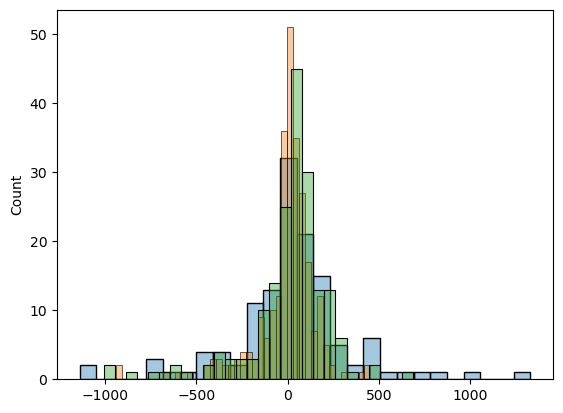

In [254]:
for plot in [BTC_CNNGRU_pnl, BTC_CNN_pnl, BTC_GRU_pnl]:
    sns.histplot(plot, kde=False, alpha=0.4)
plt.show()

# ETH

In [236]:
ETH_CNNGRU_exec = ExecutionHandler(dataset=eth, model=CNNGRU,
                                   model_id=f"ETH",
                                   device=device, batch_size=BATCH_SIZE, lr=LR, 
                                   timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                   train_start_idx=0, test_end_idx=len(eth),
                                   checkpoints_path='./checkpoints-hyper-test',
                                   preload_weights_path=None,
                                   transform1=to_tensor, transform2=normalise,
                                   transform3=reshape_tsr)
ETH_CNNGRU_exec.run()
print(ETH_CNNGRU_exec.model_trainer.test_confusion_matrix)

EPOCH [1/500],	 Train Loss: 0.81, Val Loss: 1.12, Train f1 (macro): 0.59, Val f1 (macro): 0.24, Elapsed time: 0m 22s
EPOCH [10/500],	 Train Loss: 0.32, Val Loss: 0.87, Train f1 (macro): 0.88, Val f1 (macro): 0.33, Elapsed time: 3m 37s
EPOCH [20/500],	 Train Loss: 0.23, Val Loss: 0.69, Train f1 (macro): 0.91, Val f1 (macro): 0.37, Elapsed time: 7m 23s
Training completed in 9m 60s for CNNGRU.
Total epochs trained: 27
Best epoch: 16
Best val loss: 0.6367717201893146
Best val f1 (macro): 0.3745954532402589
[[8951 1320 1167]
 [ 103  131    1]
 [ 121    0  114]]


In [237]:
ETH_CNN_exec = ExecutionHandler(dataset=eth, model=CNN,
                                   model_id=f"ETH",
                                   device=device, batch_size=BATCH_SIZE, lr=LR, 
                                   timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                   train_start_idx=0, test_end_idx=len(eth),
                                   checkpoints_path='./checkpoints-hyper-test',
                                   preload_weights_path=None,
                                   transform1=to_tensor, transform2=normalise,
                                   transform3=reshape_tsr)
ETH_CNN_exec.run()
print(ETH_CNN_exec.model_trainer.test_confusion_matrix)

EPOCH [1/500],	 Train Loss: 0.66, Val Loss: 1.06, Train f1 (macro): 0.68, Val f1 (macro): 0.30, Elapsed time: 0m 19s
EPOCH [10/500],	 Train Loss: 0.24, Val Loss: 0.59, Train f1 (macro): 0.91, Val f1 (macro): 0.42, Elapsed time: 3m 6s
EPOCH [20/500],	 Train Loss: 0.16, Val Loss: 0.52, Train f1 (macro): 0.94, Val f1 (macro): 0.44, Elapsed time: 6m 12s
Training completed in 6m 31s for CNN.
Total epochs trained: 21
Best epoch: 10
Best val loss: 0.4712725585469833
Best val f1 (macro): 0.4463574876398862
[[9579  881  978]
 [  81  154    0]
 [  77    0  158]]


In [238]:
ETH_GRU_exec = ExecutionHandler(dataset=eth, model=GRU,
                                   model_id=f"ETH",
                                   device=device, batch_size=BATCH_SIZE, lr=LR, 
                                   timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                   train_start_idx=0, test_end_idx=len(eth),
                                   checkpoints_path='./checkpoints-hyper-test',
                                   preload_weights_path=None,
                                   transform1=to_tensor, transform2=normalise,
                                   transform3=reshape_tsr)
ETH_GRU_exec.run()
print(ETH_GRU_exec.model_trainer.test_confusion_matrix)

EPOCH [1/500],	 Train Loss: 0.65, Val Loss: 0.76, Train f1 (macro): 0.69, Val f1 (macro): 0.35, Elapsed time: 0m 22s
EPOCH [10/500],	 Train Loss: 0.24, Val Loss: 0.59, Train f1 (macro): 0.93, Val f1 (macro): 0.43, Elapsed time: 3m 44s
Training completed in 6m 42s for GRU.
Total epochs trained: 18
Best epoch: 7
Best val loss: 0.4834167023117726
Best val f1 (macro): 0.43916861325021944
[[9564  985  889]
 [  56  179    0]
 [  67    0  168]]


# BNB

In [239]:
BNB_CNNGRU_exec = ExecutionHandler(dataset=bnb, model=CNNGRU,
                                   model_id=f"BNB",
                                   device=device, batch_size=BATCH_SIZE, lr=LR, 
                                   timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                   train_start_idx=0, test_end_idx=len(bnb),
                                   checkpoints_path='./checkpoints-hyper-test',
                                   preload_weights_path=None,
                                   transform1=to_tensor, transform2=normalise,
                                   transform3=reshape_tsr)
BNB_CNNGRU_exec.run()
print(BNB_CNNGRU_exec.model_trainer.test_confusion_matrix)

EPOCH [1/500],	 Train Loss: 0.82, Val Loss: 1.18, Train f1 (macro): 0.58, Val f1 (macro): 0.22, Elapsed time: 0m 23s
EPOCH [10/500],	 Train Loss: 0.22, Val Loss: 0.72, Train f1 (macro): 0.92, Val f1 (macro): 0.40, Elapsed time: 3m 46s
EPOCH [20/500],	 Train Loss: 0.09, Val Loss: 0.40, Train f1 (macro): 0.97, Val f1 (macro): 0.44, Elapsed time: 7m 28s
EPOCH [30/500],	 Train Loss: 0.06, Val Loss: 0.39, Train f1 (macro): 0.98, Val f1 (macro): 0.43, Elapsed time: 11m 11s
Training completed in 11m 33s for CNNGRU.
Total epochs trained: 31
Best epoch: 20
Best val loss: 0.37985037467800653
Best val f1 (macro): 0.4410824187117477
[[10606   410   408]
 [  150    92     0]
 [  181     0    61]]


In [240]:
BNB_CNN_exec = ExecutionHandler(dataset=bnb, model=CNN,
                                   model_id=f"BNB",
                                   device=device, batch_size=BATCH_SIZE, lr=LR, 
                                   timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                   train_start_idx=0, test_end_idx=len(bnb),
                                   checkpoints_path='./checkpoints-hyper-test',
                                   preload_weights_path=None,
                                   transform1=to_tensor, transform2=normalise,
                                   transform3=reshape_tsr)
BNB_CNN_exec.run()
print(BNB_CNN_exec.model_trainer.test_confusion_matrix)

EPOCH [1/500],	 Train Loss: 0.63, Val Loss: 1.18, Train f1 (macro): 0.70, Val f1 (macro): 0.27, Elapsed time: 0m 19s
EPOCH [10/500],	 Train Loss: 0.22, Val Loss: 0.71, Train f1 (macro): 0.92, Val f1 (macro): 0.42, Elapsed time: 3m 6s
Training completed in 5m 16s for CNN.
Total epochs trained: 17
Best epoch: 6
Best val loss: 0.38912933892928636
Best val f1 (macro): 0.45523142225179775
[[9908  883  633]
 [  71  171    0]
 [ 129    0  113]]


In [241]:
BNB_GRU_exec = ExecutionHandler(dataset=bnb, model=GRU,
                                   model_id=f"BNB",
                                   device=device, batch_size=BATCH_SIZE, lr=LR, 
                                   timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                   train_start_idx=0, test_end_idx=len(bnb),
                                   checkpoints_path='./checkpoints-hyper-test',
                                   preload_weights_path=None,
                                   transform1=to_tensor, transform2=normalise,
                                   transform3=reshape_tsr)
BNB_GRU_exec.run()
print(BNB_GRU_exec.model_trainer.test_confusion_matrix)

EPOCH [1/500],	 Train Loss: 0.68, Val Loss: 1.14, Train f1 (macro): 0.67, Val f1 (macro): 0.30, Elapsed time: 0m 23s
EPOCH [10/500],	 Train Loss: 0.24, Val Loss: 0.43, Train f1 (macro): 0.93, Val f1 (macro): 0.45, Elapsed time: 3m 45s
EPOCH [20/500],	 Train Loss: 0.16, Val Loss: 0.51, Train f1 (macro): 0.96, Val f1 (macro): 0.45, Elapsed time: 7m 20s
Training completed in 7m 20s for GRU.
Total epochs trained: 20
Best epoch: 9
Best val loss: 0.4288309130531091
Best val f1 (macro): 0.4499908707784395
[[9749  914  761]
 [  81  161    0]
 [ 114    0  128]]


## BTC

In [116]:
BTC_test_df = generate_preds(df_test=BTC_CNNGRU_exec.loader_gen.test_df, 
                             model_name='CNNGRU',
                             test_preds=BTC_CNNGRU_exec.model_trainer.test_pred_y.numpy(),
                             timeperiod=TIMEPERIOD)

BTC_test_df = generate_preds(df_test=BTC_test_df, 
                             model_name='CNN',
                             test_preds=BTC_CNN_exec.model_trainer.test_pred_y.numpy(),
                             timeperiod=TIMEPERIOD)

BTC_test_df = generate_preds(df_test=BTC_test_df, 
                             model_name='GRU',
                             test_preds=BTC_GRU_exec.model_trainer.test_pred_y.numpy(),
                             timeperiod=TIMEPERIOD)

In [132]:
BTC_simulator = SimulatedTradingSession(df=BTC_test_df, model_name="CNNGRU", 
                                        ticker="BTC", stake_size=1.0, 
                                        signal="signal_pred", stoploss=1, trailing_stop=True)
BTC_simulator.backtest()
BTC_simulator.get_cumulative_returns()

BTC_simulator = SimulatedTradingSession(df=BTC_simulator.df, model_name="CNN", 
                                        ticker="BTC", stake_size=1.0, 
                                        signal="signal_pred", stoploss=1, trailing_stop=True)
BTC_simulator.backtest()
BTC_simulator.get_cumulative_returns()

BTC_simulator = SimulatedTradingSession(df=BTC_simulator.df, model_name="GRU", 
                                        ticker="BTC", stake_size=1.0, 
                                        signal="signal_pred", stoploss=1, trailing_stop=True)
BTC_simulator.backtest()
BTC_simulator.get_cumulative_returns()


Starting backtest on BTC...
Opening balance: 10000.00
Backtest finished.
Closing balance: 12610.19, PNL: 2610.19
Open order: {'ticker': 'BTC', 'date_open': Timestamp('2024-05-11 01:00:00+0000', tz='UTC'), 'quantity_open': 0.20763696800501458, 'price_open': 60779.99, 'date_close': None, 'quantity_close': None, 'price_close': None, 'fee_open': 12.632805644619726, 'fee_close': None, 'fee_total': 12.632805644619726, 'closed': False, 'pnl': None}
Starting backtest on BTC...
Opening balance: 10000.00
Backtest finished.
Closing balance: 7357.02, PNL: -2642.98
Open order: {'ticker': 'BTC', 'date_open': Timestamp('2024-05-10 15:00:00+0000', tz='UTC'), 'quantity_open': 0.1211392404360526, 'price_open': 61063.87, 'date_close': None, 'quantity_close': None, 'price_close': None, 'fee_open': 7.404635465351211, 'fee_close': None, 'fee_total': 7.404635465351211, 'closed': False, 'pnl': None}
Starting backtest on BTC...
Opening balance: 10000.00
Backtest finished.
Closing balance: 11178.85, PNL: 1178.8

In [133]:
BTC_cum_rets_df = BTC_simulator.df[["date", "CNNGRU", "CNN", "GRU"]]
BTC_cum_rets_df = BTC_cum_rets_df.melt("date", var_name='Model',  value_name='vals')

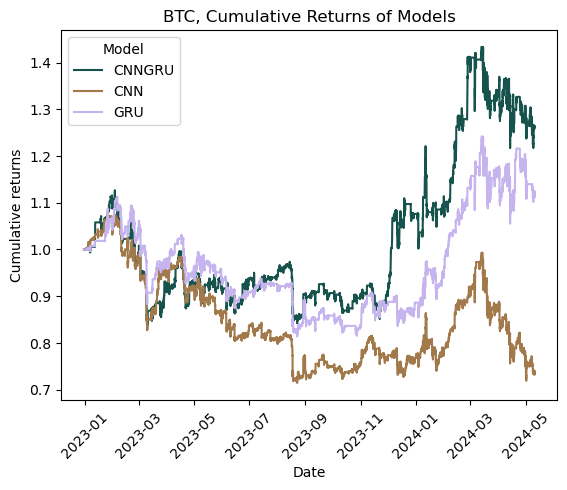

In [134]:
sns.lineplot(data=BTC_cum_rets_df, 
             x="date", y="vals", hue="Model", palette="cubehelix")
plt.title("BTC, Cumulative Returns of Models")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Cumulative returns")
# plt.savefig("btc_cumrets.png", bbox_inches='tight')
plt.show()

## ETH 

In [135]:
# Generate test df
ETH_test_df = generate_preds(df_test=ETH_CNNGRU_exec.loader_gen.test_df, 
                             model_name='CNNGRU',
                             test_preds=ETH_CNNGRU_exec.model_trainer.test_pred_y.numpy(),
                             timeperiod=TIMEPERIOD)

ETH_test_df = generate_preds(df_test=ETH_test_df, 
                             model_name='CNN',
                             test_preds=ETH_CNN_exec.model_trainer.test_pred_y.numpy(),
                             timeperiod=TIMEPERIOD)

ETH_test_df = generate_preds(df_test=ETH_test_df, 
                             model_name='GRU',
                             test_preds=ETH_GRU_exec.model_trainer.test_pred_y.numpy(),
                             timeperiod=TIMEPERIOD)

# Simulation
ETH_simulator = SimulatedTradingSession(df=ETH_test_df, model_name="CNNGRU", 
                                        ticker="ETH", stake_size=1.0, 
                                        signal="signal_pred", stoploss=1, trailing_stop=True)
ETH_simulator.backtest()
ETH_simulator.get_cumulative_returns()

ETH_simulator = SimulatedTradingSession(df=ETH_simulator.df, model_name="CNN", 
                                        ticker="ETH", stake_size=1.0, 
                                        signal="signal_pred", stoploss=1, trailing_stop=True)
ETH_simulator.backtest()
ETH_simulator.get_cumulative_returns()

ETH_simulator = SimulatedTradingSession(df=ETH_simulator.df, model_name="GRU", 
                                        ticker="ETH", stake_size=1.0, 
                                        signal="signal_pred", stoploss=1, trailing_stop=True)
ETH_simulator.backtest()
ETH_simulator.get_cumulative_returns()

# Get cumulative returns df
ETH_cum_rets_df = ETH_simulator.df[["date", "CNNGRU", "CNN", "GRU"]]
ETH_cum_rets_df = ETH_cum_rets_df.melt("date", var_name='Model',  value_name='vals')

Starting backtest on ETH...
Opening balance: 10000.00
Backtest finished.
Closing balance: 11719.68, PNL: 1719.68
Open order: {'ticker': 'ETH', 'date_open': Timestamp('2024-05-10 15:00:00+0000', tz='UTC'), 'quantity_open': 4.025997629665684, 'price_open': 2935.79, 'date_close': None, 'quantity_close': None, 'price_close': None, 'fee_open': 11.831314896092312, 'fee_close': None, 'fee_total': 11.831314896092312, 'closed': False, 'pnl': None}
Starting backtest on ETH...
Opening balance: 10000.00
Backtest finished.
Closing balance: 7308.72, PNL: -2691.28
Open order: {'ticker': 'ETH', 'date_open': Timestamp('2024-05-10 15:00:00+0000', tz='UTC'), 'quantity_open': 2.5107249353113157, 'price_open': 2935.79, 'date_close': None, 'quantity_close': None, 'price_close': None, 'fee_open': 7.378339497334943, 'fee_close': None, 'fee_total': 7.378339497334943, 'closed': False, 'pnl': None}
Starting backtest on ETH...
Opening balance: 10000.00
Backtest finished.
Closing balance: 10010.48, PNL: 10.48
Open

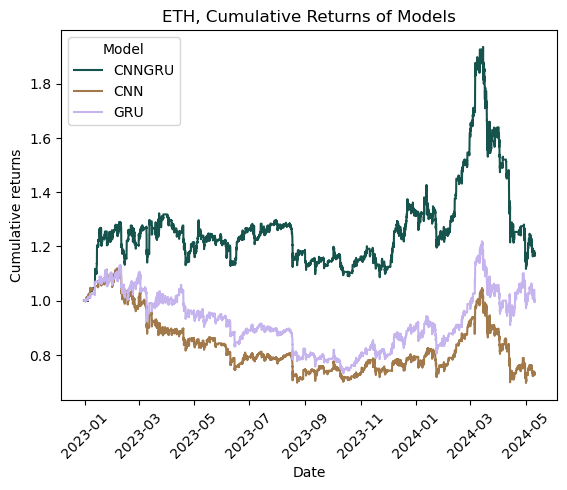

In [136]:
sns.lineplot(data=ETH_cum_rets_df, 
             x="date", y="vals", hue="Model", palette="cubehelix")
plt.title("ETH, Cumulative Returns of Models")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Cumulative returns")
# plt.savefig("eth_cumrets.png", bbox_inches='tight')
plt.show()

## BNB

In [137]:
# Generate test df
BNB_test_df = generate_preds(df_test=BNB_CNNGRU_exec.loader_gen.test_df, 
                             model_name='CNNGRU',
                             test_preds=BNB_CNNGRU_exec.model_trainer.test_pred_y.numpy(),
                             timeperiod=TIMEPERIOD)

BNB_test_df = generate_preds(df_test=BNB_test_df, 
                             model_name='CNN',
                             test_preds=BNB_CNN_exec.model_trainer.test_pred_y.numpy(),
                             timeperiod=TIMEPERIOD)

BNB_test_df = generate_preds(df_test=BNB_test_df, 
                             model_name='GRU',
                             test_preds=BNB_GRU_exec.model_trainer.test_pred_y.numpy(),
                             timeperiod=TIMEPERIOD)

# Simulation
BNB_simulator = SimulatedTradingSession(df=BNB_test_df, model_name="CNNGRU", 
                                        ticker="BNB", stake_size=1.0, 
                                        signal="signal_pred", stoploss=1, trailing_stop=True)
BNB_simulator.backtest()
BNB_simulator.get_cumulative_returns()

BNB_simulator = SimulatedTradingSession(df=BNB_simulator.df, model_name="CNN", 
                                        ticker="BNB", stake_size=1.0, 
                                        signal="signal_pred", stoploss=1, trailing_stop=True)
BNB_simulator.backtest()
BNB_simulator.get_cumulative_returns()

BNB_simulator = SimulatedTradingSession(df=BNB_simulator.df, model_name="GRU", 
                                        ticker="BNB", stake_size=1.0, 
                                        signal="signal_pred", stoploss=1, trailing_stop=True)
BNB_simulator.backtest()
BNB_simulator.get_cumulative_returns()

# Get cumulative returns df
BNB_cum_rets_df = BNB_simulator.df[["date", "CNNGRU", "CNN", "GRU"]]
BNB_cum_rets_df = BNB_cum_rets_df.melt("date", var_name='Model',  value_name='vals')

Starting backtest on BNB...
Opening balance: 10000.00
Backtest finished.
Closing balance: 23254.70, PNL: 13254.70
Open order: {'ticker': 'BNB', 'date_open': Timestamp('2024-05-04 18:00:00+0000', tz='UTC'), 'quantity_open': 39.8606499107655, 'price_open': 587.5, 'date_close': None, 'quantity_close': None, 'price_close': None, 'fee_open': 23.441573395970703, 'fee_close': None, 'fee_total': 23.441573395970703, 'closed': False, 'pnl': None}
Starting backtest on BNB...
Opening balance: 10000.00
Backtest finished.
Closing balance: 13442.79, PNL: 3442.79
Open order: {'ticker': 'BNB', 'date_open': Timestamp('2024-05-10 15:00:00+0000', tz='UTC'), 'quantity_open': 23.04215658500509, 'price_open': 586.3, 'date_close': None, 'quantity_close': None, 'price_close': None, 'fee_open': 13.523139545333816, 'fee_close': None, 'fee_total': 13.523139545333816, 'closed': False, 'pnl': None}
Starting backtest on BNB...
Opening balance: 10000.00
Backtest finished.
Closing balance: 9714.23, PNL: -285.77
Open o

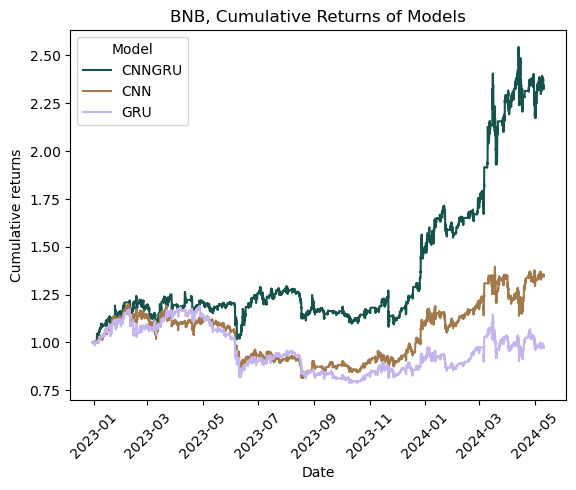

In [138]:
sns.lineplot(data=BNB_cum_rets_df, 
             x="date", y="vals", hue="Model", palette="cubehelix")
plt.title("BNB, Cumulative Returns of Models")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Cumulative returns")
# plt.savefig("bnb_cumrets.png", bbox_inches='tight')
plt.show()

In [153]:
def annualised_returns(start_value:float, end_value:float, 
                       start_date:pd.Timestamp, end_date:pd.Timestamp):
    n_years = (end_date - start_date).days / 365
    ann_rets = (end_value/start_value) ** (1/n_years) - 1
    return ann_rets
    

In [154]:
sd = pd.to_datetime("2023-01-01 00:00:00+00:00")
ed = pd.to_datetime("2024-05-11 04:00:00+00:00")

In [158]:
annualised_returns(10000.00, 9714.23, sd, ed)

-0.021109777379183292